# Import package and function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
import import_ipynb
os.chdir('Modules')
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState


importing Jupyter notebook from time_shifted_PID.ipynb


# LED

In [3]:
Fc_list = [2,4,7,10, np.inf]
os.chdir('..')
os.chdir('..')
data_folder = os.getcwd()+"\\Experimental_Data_Example\\LED_Data\\"
file_list = ['20200408_OU_cutoff=2_sort_unit2',
             '20200408_OU_cutoff=4_sort_unit2',
             '20200408_OU_cutoff=7_sort_unit2',
             '20200408_OU_cutoff=10_sort_unit2',
             '20200408_OU_original_tau=0p5_sort_unit2']

dt = 0.01
pcn = 53
ncn = 41

In [4]:
x_list = []
T_list = []
prstate_list = []
nrstate_list = []

for file in file_list:
    file = data_folder+file
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T=np.arange(len(x))*dt+dt
    prstate,_ = np.histogram(annots['Spikes'][pcn-1]-TimeStamps[0], np.append(0,T))
    nrstate,_ = np.histogram(annots['Spikes'][ncn-1]-TimeStamps[0], np.append(0,T))
    prstate_list.append( prstate.copy() )
    nrstate_list.append( nrstate.copy() )
    x_list.append( x.copy() )
    T_list.append( T.copy() )

In [5]:
v_list = [ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list]

In [6]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]

In [7]:
window = [-1,1] # second
ip_Information_list = [0]*len(x_list)
in_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    LEDtimeshift, ip_Information_list[i] = PIfunc(prstate_list[i], xstate_list[i], vstate_list[i], dt, window)
    LEDtimeshift, in_Information_list[i] = PIfunc(nrstate_list[i], xstate_list[i], vstate_list[i], dt, window)
# Information_list = Real_Information_list.copy()

# OLED

In [8]:
Fc_list = [1,2,4, np.inf]
data_folder = os.getcwd()+"\\Experimental_Data_Example\\OLED_Data\\"
file_list = ['merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_0.5Hz.mat',
             'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_1Hz.mat',
             'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_2Hz.mat',
             'merge_0727_OUsmooth_Bright_UD_G4.5_5min_Q100_6.5mW_4Hz.mat']

dt = 1/60
pcn = 9
ncn = 15

In [9]:
x_list = []
prstate_list = []
nrstate_list = []

for file in file_list:
    file = data_folder+file
    annots = loadmat(file, squeeze_me = True)
    x = annots['bin_pos']
    x = (x-np.mean(x))/np.std(x)
    prstate, _ = np.histogram(annots['reconstruct_spikes'][pcn-1], np.arange(len(x)+1)*dt)
    nrstate, _ = np.histogram(annots['reconstruct_spikes'][ncn-1], np.arange(len(x)+1)*dt)
    prstate_list.append( prstate.copy() )
    nrstate_list.append( nrstate.copy() )
    x_list.append( x.copy() )

In [10]:
v_list = [ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list]

state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]

In [11]:
window = [-1,1] # second
mp_Information_list = [0]*len(x_list)
mn_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    OLEDtimeshift, mp_Information_list[i] = PIfunc(prstate_list[i], xstate_list[i], vstate_list[i], dt, window)
    OLEDtimeshift, mn_Information_list[i] = PIfunc(nrstate_list[i], xstate_list[i], vstate_list[i], dt, window)

# Figure 3.7: Typical TLMI I(γ, Ξ, δt) of RGCs.

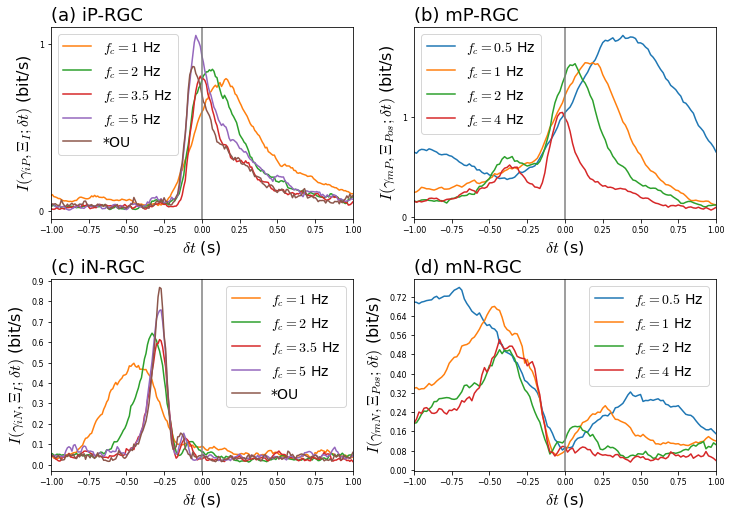

In [12]:
plt.rcParams["font.size"] = 8

fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
Information_list = ip_Information_list.copy()
timeshift = LEDtimeshift
for i in range(5):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], c = plt.cm.tab10(i+1))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel(r'$I(\gamma_{iP}, \Xi_I; \delta t)$ (bit/s)', fontsize = 16)
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)
ax2.set_title('(a) iP-RGC', fontsize = 18, loc = 'left')
ax2.legend( (r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=3.5$ Hz', r'$f_c=5$ Hz', '*OU'), loc='best', prop={'size': 14})

Information_list = mp_Information_list.copy()
timeshift = OLEDtimeshift
for i in range(4):
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel(r'$I(\gamma_{mP}, \Xi_{Pos}; \delta t)$ (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.set_title('(b) mP-RGC', fontsize = 18, loc = 'left')
ax3.legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'), loc='best', prop={'size': 14})

Information_list = in_Information_list.copy()
timeshift = LEDtimeshift
for i in range(5):
    ax4.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], c = plt.cm.tab10(i+1))
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))
ax4.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax4.set_ylabel(r'$I(\gamma_{iN}, \Xi_I; \delta t)$ (bit/s)', fontsize = 16)
ax4.axvline(0, c = 'gray')
ax4.set_xlim(window)
ax4.set_title('(c) iN-RGC', fontsize = 18, loc = 'left')
ax4.legend( (r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=3.5$ Hz', r'$f_c=5$ Hz', '*OU'), loc='best', prop={'size': 14})

Information_list = mn_Information_list.copy()
timeshift = OLEDtimeshift
for i in range(4):
    ax5.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
ax5.yaxis.set_major_locator(MaxNLocator(integer=True))
ax5.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax5.set_ylabel(r'$I(\gamma_{mN}, \Xi_{Pos}; \delta t)$ (bit/s)', fontsize = 16)
ax5.axvline(0, c = 'gray')
ax5.set_xlim(window)
ax5.set_title('(d) mN-RGC', fontsize = 18, loc = 'left')
ax5.legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'), loc='best', prop={'size': 14})

fig.set_size_inches(10, 7)

# Figure 3.8 (a): Typical TLMI and TLPI of the iP-RGC

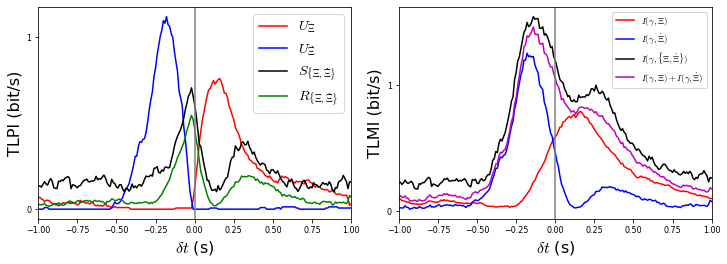

In [20]:
plt.rcParams["font.size"] = 8

i = 0
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
Information_list = ip_Information_list
timeshift = LEDtimeshift
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
           loc='best', prop={'size': 9})

# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)